In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_coronagraphy
from pynrc.obs_nircam import plot_contrasts, planet_mags, plot_planet_patches

from pynrc.speckle_noise import offset_bar
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import (fits, ascii)

# Observation Definitions

Functions to create and optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk=False, 
            subsize=None, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    
    if sp_ref is None: sp_ref = sp_sci

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        # Create identification key
        key = make_key(filt, mask=mask, pupil=pupil)
        if verbose: print(key)

        # Disk Model
        if args_disk is None:
            hdu_disk = None
        else:
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)

        # Define the subarray readout size
        if subsize is None:
            if mask is None: # Direct Imaging
                subsize = 400
            elif ('210R' in mask) or ('SWB' in mask): # SW Coronagraphy
                subsize = 640
            else: # LW Coronagraphy
                subsize = 320
                
        # Define PSF pixel size
        fov_pix_orig = fov_pix
        fov_pix = subsize if fov_pix is None else fov_pix
        if np.mod(fov_pix,2)==0: fov_pix += 1

        # Other coronagraph vs direct imaging settings
        module, oversample = ('B', 4) if mask is None else ('A', 2)
        
        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_hci(sp_sci, sp_ref, dist, filter=filt, mask=mask, pupil=pupil, 
                                      wfe_ref_drift=wfe_drift, fov_pix=fov_pix, oversample=oversample, 
                                      wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                      disk_hdu=hdu_disk, verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

In [5]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None, **kwargs):
    """
    kwargs to pass to calc_contrast() and their defaults:

    exclude_disk = True
    exclude_planets = True
    exclude_noise = False
    opt_diff = True
    """
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_filter[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_ref_drift in wfe_list:
            obs.wfe_ref_drift = wfe_ref_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, **kwargs)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

# Sources and Bandpasses

In [6]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [21]:
# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('51 Eri',  29.4, 1000, 'F0IV', 7331, -0.12, 3.95, 4.54, bp_k),
                ('HR 8799', 39.0,   30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)]

# References     source,    sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('HD 30562',   'F8V', 5875, +0.22, 4.14, 4.31, bp_k), # da Silva, et al. (2015)
               ('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)]

In [22]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'Exoplanets/'

## 1. 51 Eri

In [23]:
# List of filters
args_filter = [('F322W2', 'MASK430R', 'CIRCLYOT'),
               ('F444W',  'MASK430R', 'CIRCLYOT')]

args_filter = [('F335M', 'MASK430R', 'CIRCLYOT'),
               ('F444W',  'MASK430R', 'CIRCLYOT')]


# and their dictionary keys
filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [10]:
# Fit spectrum to SED photometry

i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = nrc_utils.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=True, robust=True)

# Final source spectrum
sp_sci = src.sp_model

[ 0.98238527]


In [24]:
# Do the same for the reference source

name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[ 1.05069841]


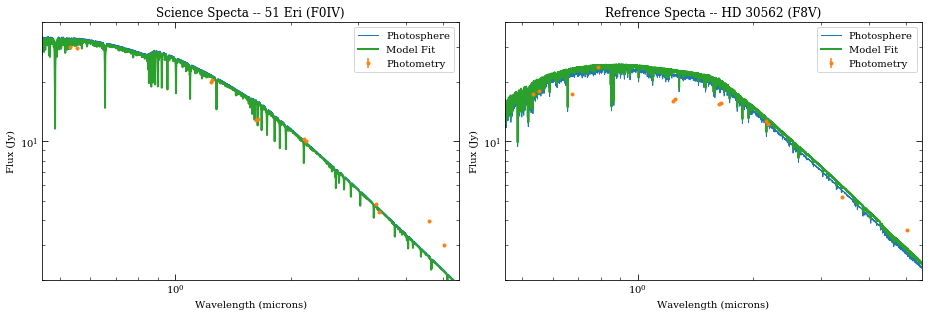

In [25]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
src.plot_SED(xr=[0.45,5.5], yr=[2,40], ax=axes[0])
ref.plot_SED(xr=[0.45,5.5], yr=[2,40], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci))

In [13]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   args_disk=None, fov_pix=None, verbose=True)

F322W2_MASK430R_CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F444W_MASK430R_CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [14]:
# Update exposure times (per roll)

# Filter Key : (Pattern, NG, NINT_sci, NINT_ref)
exp_dict = {'F322W2_MASK430R_CIRCLYOT': ('MEDIUM8', 10, 5, 5),
            'F444W_MASK430R_CIRCLYOT' : ('DEEP8',   10, 5, 5)}

for key in filt_keys:
    obs = obs_dict[key]
    
    rm, ng, nint_sci, nint_ref = exp_dict[key] 
    obs.update_detectors(read_mode=rm, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=rm, ngroup=ng, nint=nint_ref)

    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')


F322W2_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 523.8296, 't_acq': 529.2744, 't_int_tot': 105.85488}
Point Source Sensitivity (5-sigma): 22.61 vegamag
Surface Brightness Sensitivity (5-sigma): 23.54 vegamag/arcsec^2

F444W_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 21.3808, 't_int': 200.97952, 't_exp': 1004.8976, 't_acq': 1010.3424000000001, 't_int_tot': 202.06848000000002}
Point Source Sensitivity (5-sigma): 21.41 vegamag
Surface Brightness Sensitivity (5-sigma): 22.67 vegamag/arcsec^2



### Saturation Levels

In [15]:
# Max Saturation values and locations (80% at 2 groups)
for key in filt_keys:
    print(key)
    obs = obs_dict[key]
    
    ng = 2
    im_sat1 = obs.saturation_levels(ngroup=ng)
    im_sat2 = obs.nrc_ref.saturation_levels(obs.sp_ref, ngroup=ng)
    dist1 = nrc_utils.dist_image(im_sat1, pixscale=obs.pix_scale)
    dist2 = nrc_utils.dist_image(im_sat2, pixscale=obs.pix_scale)
    dmax1 = np.max(dist1[im_sat1==im_sat1.max()])
    dmax2 = np.max(dist2[im_sat2==im_sat2.max()])
    
    print('Max sci saturation of {:.1f} well at {:.1f} arcsec'.format(im_sat1.max(), dmax1))
    print('Max ref saturation of {:.1f} well at {:.1f} arcsec'.format(im_sat2.max(), dmax2))


F322W2_MASK430R_CIRCLYOT
Max sci saturation of 0.4 well at 0.3 arcsec
Max ref saturation of 0.5 well at 0.3 arcsec
F444W_MASK430R_CIRCLYOT
Max sci saturation of 0.1 well at 0.5 arcsec
Max ref saturation of 0.1 well at 0.5 arcsec


### Contrast Curves

In [16]:
# List of WFE drifts to check
wfe_list = [0,2,5,10][::-1]
nsig = 5

# Get contrasts for each WFE drift
contrast_dict = do_contrast(wfe_list, filt_keys, nsig=nsig, roll_angle=10)

F322W2_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


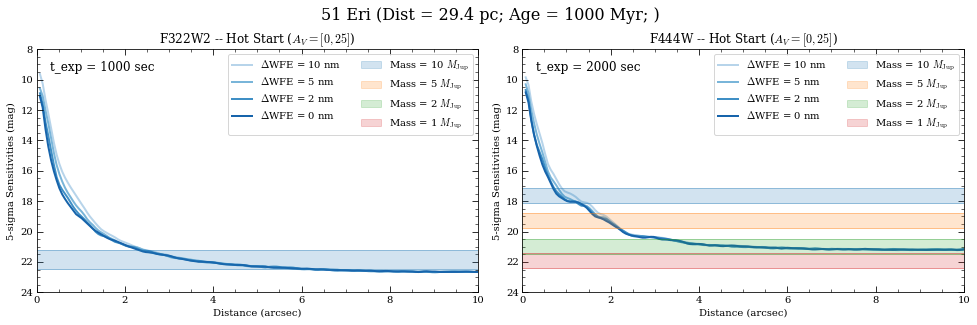

In [17]:
xlim=[0,10]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
#entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    obs = obs_dict[filt_keys[j]]
    curves = contrast_dict[filt_keys[j]]

    plot_contrasts(curves, wfe_list, ax=ax)
    plot_planet_patches(ax, obs, age=age, entropy=13)

    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    ax.text(0.03,0.95,'t_exp = {:.0f} sec'.format(t_exp), transform=ax.transAxes,
            horizontalalignment='left', verticalalignment='top', fontsize=12)

    
for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
    ax.legend(ncol=2)

dist_str = 'Dist = {:.1f} pc; '.format(dist_sci)
age_str = 'Age = {:.0f} Myr; '.format(age)
fig.suptitle('{} ({}{})'.format(name_sci, dist_str, age_str), fontsize=16);

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

save_fig = True
fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
if save_fig: 
    fig.savefig(outdir+fname)

### Target Acquisition

In [18]:
# Cycle through various TA settings and print out saturation and SNR levels
# This uses the ramp_optimize method, but constrains the ngroups to a 
# specific setting.
nrc = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', ND_acq=True,
                   wind_mode='WINDOW', xpix=64, ypix=64)

pynrc.setup_logging('ERROR', verbose=False)
ng_levels = [3,5,9,17,33,65]
patterns = ['RAPID', 'BRIGHT2', 'SHALLOW4', 'MEDIUM8']
for sp in [sp_sci, sp_ref]:
    print(sp.name)
    for ng in ng_levels: 
        tbl = nrc.ramp_optimize(sp, snr_goal=50, well_frac_max=0.5, verbose=False,
                                ng_min=ng, ng_max=ng, nint_max=1, patterns=patterns)
        if len(tbl)>0:
            print(tbl)
    print('')

pynrc.setup_logging('WARNING', verbose=False)

51 Eri
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8       3    1      1.40      1.40      1.46     71.1    0.019   58.873
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8       5    1      2.41      2.41      2.46    104.5    0.032   66.592
SHALLOW4      5    1      1.20      1.20      1.26     68.6    0.016   61.141
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8       9    1      4.41      4.41      4.47    151.0    0.059   71.419
SHALLOW4      9    1      2.21      2.21      2.26    103.5    0.030   68.807
BRIGHT2       9    1      0.90      0.90      0.96     57.9    0.012   59.157
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR 